In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
import cv2 
import os 
from random import shuffle 
from tqdm import tqdm 
from PIL import Image

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, root_mean_squared_error, confusion_matrix
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
# image_subset = []

# with open("../data/CXR8/all_list.txt", 'r') as allImages:
#     for line in allImages:
#         image_subset.append(str.strip(line))
    
#     allImages.close()

In [3]:
# data_entry = pd.read_csv("../data/CXR8/Data_Entry_2017_v2020.csv")
# data_filtered_entry = data_entry[data_entry['Image Index'].apply(lambda index: index in image_subset)]

In [4]:
# data_filtered_entry = data_filtered_entry.drop(columns=['Finding Labels', 'Follow-up #'], axis=1)

In [5]:
# #LongTailCXR
# lt_test = pd.read_csv("../data/CXR8/LongTailCXR/nih-cxr-lt_single-label_test.csv")
# lt_train = pd.read_csv("../data/CXR8/LongTailCXR/nih-cxr-lt_single-label_train.csv")

# #PruneCXR
# prune_test = pd.read_csv("../data/CXR8/PruneCXR/miccai2023_nih-cxr-lt_labels_test.csv")
# prune_val = pd.read_csv("../data/CXR8/PruneCXR/miccai2023_nih-cxr-lt_labels_val.csv")
# prune_train = pd.read_csv("../data/CXR8/PruneCXR/miccai2023_nih-cxr-lt_labels_train.csv")

In [6]:
# prune_data = pd.concat([prune_test, prune_train, prune_val])
# prune_filtered_data = prune_data[prune_data['id'].apply(lambda index: index in image_subset)]

In [7]:
# lt_data = pd.concat([lt_test, lt_train])
# lt_filtered_data = lt_data[lt_data['id'].apply(lambda index: index in image_subset)]

In [8]:
# prune_filtered_data.to_csv("Filtered_Data_Entry_DS541.csv")

In [9]:
prune_filtered_data = pd.read_csv("Filtered_Data_Entry_DS541.csv")

In [10]:
train_images = "../data/CXR8/images/train_val_images"

test_images = "../data/CXR8/images/test_images"


In [11]:
label_columns = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
                 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 
                 'Infiltration', 'Mass', 'Nodule', 'Pleural Thickening', 
                 'Pneumonia', 'Pneumothorax', 'Pneumoperitoneum', 'Pneumomediastinum', 
                 'Subcutaneous Emphysema', 'Tortuous Aorta', 'Calcification of the Aorta', 'No Finding']

In [12]:
label_map = {label: i for i, label in enumerate(label_columns)}

In [13]:
def train_test_preprocess_data(image_size):
    train_data = []
    train_labels = []

    test_data = []
    test_labels = []

    for image1 in tqdm(os.listdir(train_images)): 
        path = os.path.join(train_images, image1)
        img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img1 = cv2.resize(img1, (image_size, image_size))
        train_data.append(img1)
        train_labels.append(prune_filtered_data[prune_filtered_data['id'] == image1][label_columns].to_numpy())
    
    for image2 in tqdm(os.listdir(test_images)): 
        path = os.path.join(test_images, image2)
        img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img2 = cv2.resize(img2, (image_size, image_size))
        test_data.append(img2)
        test_labels.append(prune_filtered_data[prune_filtered_data['id'] == image2][label_columns].to_numpy()) 
    
    return train_data, np.array(train_labels), test_data, np.array(test_labels)

In [14]:
train_data, train_labels, test_data, test_labels = train_test_preprocess_data(image_size = 256)

100%|██████████| 2797/2797 [00:21<00:00, 130.35it/s]


In [15]:
x_data=np.concatenate((train_data,test_data),axis=0)

# #min-max scaling
# x_data = (x_data-np.min(x_data))/(np.max(x_data)-np.min(x_data))

In [16]:
y_data=np.concatenate((train_labels,test_labels),axis=0)

In [17]:
y_data = y_data.reshape(30805, 20)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=42)
number_of_train = x_train.shape[0]
number_of_test = x_test.shape[0]

In [19]:
x_train_flatten = x_train.reshape(number_of_train,x_train.shape[1]*x_train.shape[2])
x_test_flatten = x_test .reshape(number_of_test,x_test.shape[1]*x_test.shape[2])
print("X train flatten",x_train_flatten.shape)
print("X test flatten",x_test_flatten.shape)

X train flatten (26184, 65536)
X test flatten (4621, 65536)


In [20]:
def decision_tree(max_depth, x_train_flatten, y_train, x_test_flatten):
    print("\nCreating decision tree max_depth=" + str(max_depth))
    model = tree.DecisionTreeClassifier(max_depth=max_depth, class_weight='balanced')
    model.fit(x_train_flatten, y_train)
    print("Done ")
    y_pred = model.predict(x_test_flatten)

    return y_pred

In [31]:
def random_forest(estimators, x_train_flatten, y_train, x_test_flatten):
    model = RandomForestClassifier(n_estimators=estimators, class_weight='balanced')
    model.fit(x_train_flatten, y_train)
    print("Done ")
    y_pred = model.predict(x_test_flatten)
    
    return y_pred

In [22]:
dt_y_pred = decision_tree(3, x_train_flatten, y_train, x_test_flatten)



Creating decision tree max_depth=3
Done 


In [32]:
rf_y_pred = random_forest(50, x_train_flatten, y_train, x_test_flatten)


Done 


In [42]:
print("Unique classes in true labels:", np.unique(y_test.argmax(axis=1)))
print("Unique classes in predictions:", np.unique(dt_y_pred.argmax(axis=1)))

dt_cm = confusion_matrix(y_test.argmax(axis=1), dt_y_pred.argmax(axis=1))

Unique classes in true labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Unique classes in predictions: [0 2 5]


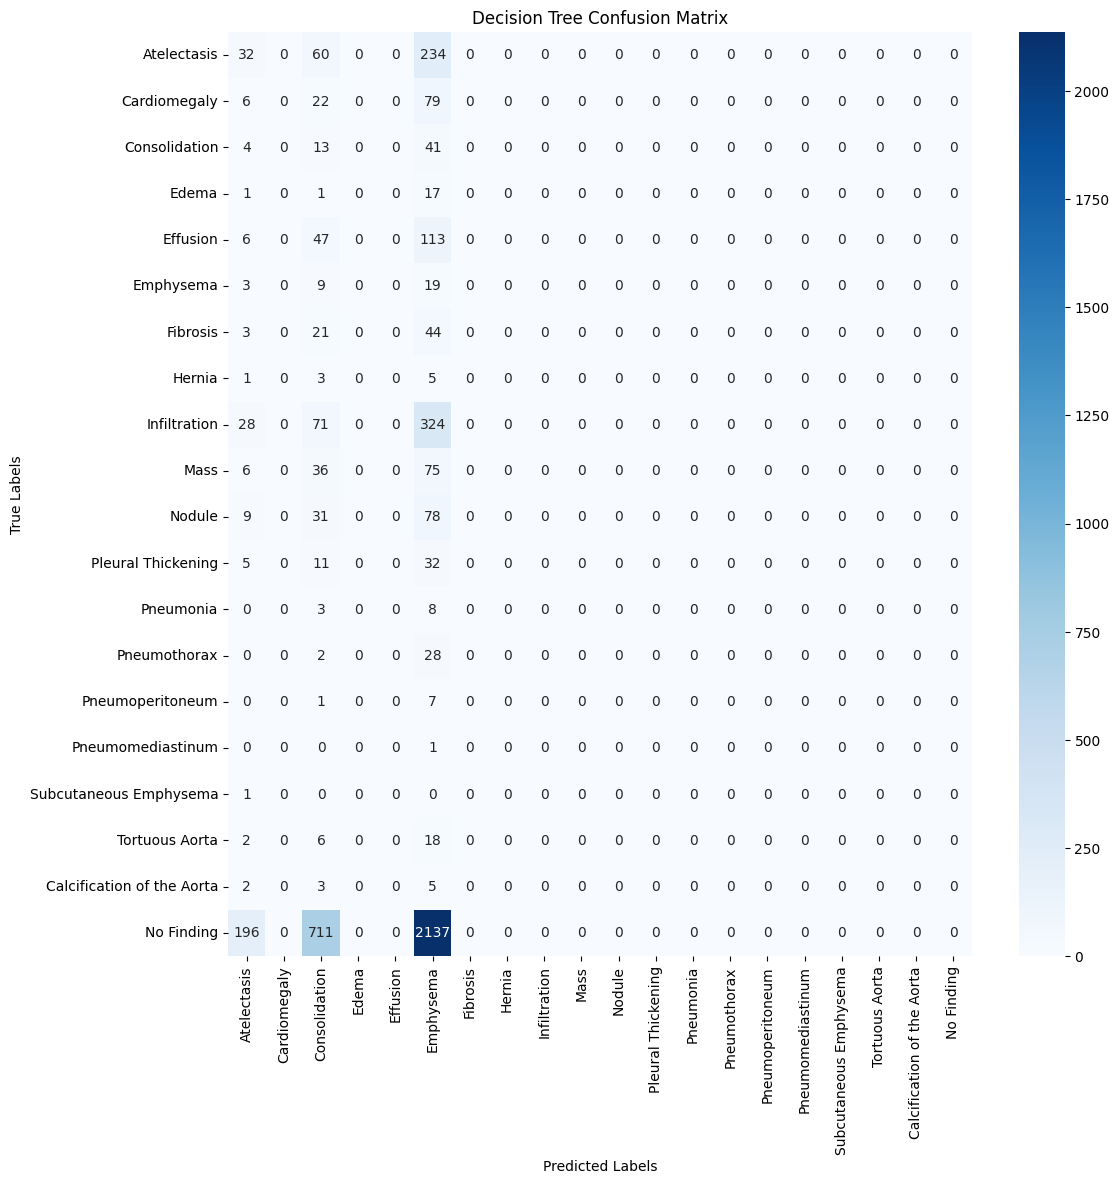

In [24]:
class_names = list(label_map.keys())

true_labeled_classes = [class_names[i] for i in range(len(class_names))]

plt.figure(figsize=(12, 12))
sns.heatmap(dt_cm, annot=True, fmt="d", xticklabels=true_labeled_classes, yticklabels=true_labeled_classes, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Decision Tree Confusion Matrix")
plt.show()

In [41]:
print("Unique classes in true labels:", np.unique(y_test.argmax(axis=1)))
print("Unique classes in predictions:", np.unique(rf_y_pred.argmax(axis=1)))

rf_cm = confusion_matrix(y_test.argmax(axis=1), rf_y_pred.argmax(axis=1))

Unique classes in true labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Unique classes in predictions: [ 0  8 19]


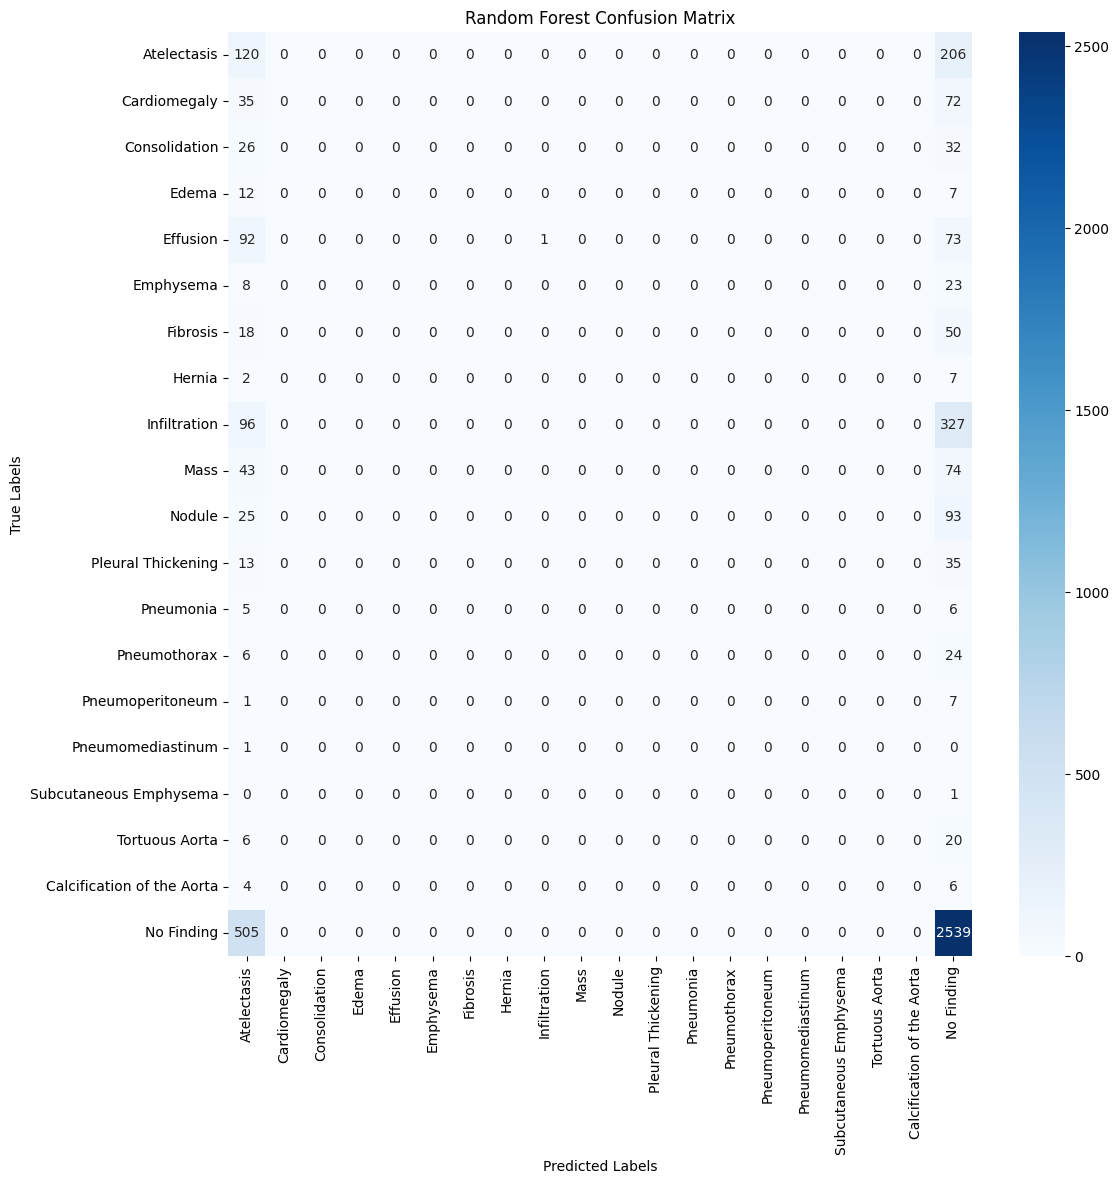

In [34]:
class_names = list(label_map.keys())

true_labeled_classes = [class_names[i] for i in range(len(class_names))]

plt.figure(figsize=(12, 12))
sns.heatmap(rf_cm, annot=True, fmt="d", xticklabels=true_labeled_classes, yticklabels=true_labeled_classes, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [43]:
print(root_mean_squared_error(y_test, rf_y_pred))
print(accuracy_score(y_test, rf_y_pred))


0.15987611896172801
0.5494481713914737


In [52]:
rf_cr = classification_report(y_test, rf_y_pred, output_dict=True)

In [53]:
rf_cr = pd.DataFrame(rf_cr).transpose()
rf_cr.drop(rf_cr.tail(4).index,inplace=True)

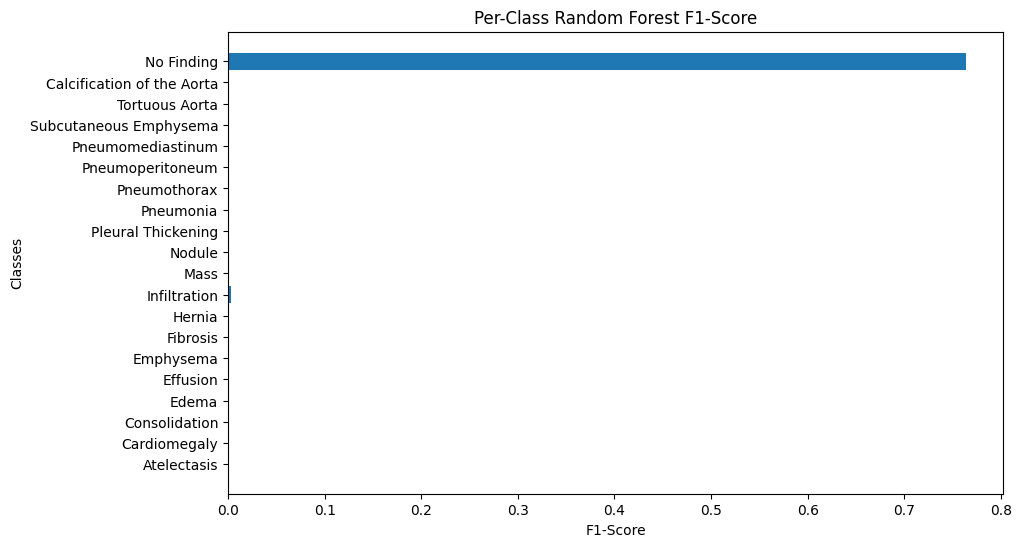

In [66]:
# Extract F1-scores for each class
f1_scores = rf_cr["f1-score"]

plt.figure(figsize=(10, 6))
plt.barh(list(label_map.keys()), f1_scores)
plt.xlabel("F1-Score")
plt.ylabel("Classes")
plt.title("Per-Class Random Forest F1-Score")
plt.show()

In [38]:
print(classification_report(y_test, dt_y_pred))

              precision    recall  f1-score   support

           0       0.10      0.10      0.10       326
           1       0.00      0.00      0.00       119
           2       0.02      0.27      0.03        81
           3       0.00      0.00      0.00        33
           4       0.06      0.28      0.10       281
           5       0.01      0.71      0.02        42
           6       0.03      0.32      0.05        91
           7       0.00      0.00      0.00        14
           8       0.13      0.79      0.23       575
           9       0.05      0.35      0.09       186
          10       0.06      0.30      0.10       227
          11       0.03      0.30      0.05       104
          12       0.00      0.00      0.00        32
          13       0.02      0.88      0.03        58
          14       0.00      0.00      0.00        18
          15       0.00      1.00      0.00         2
          16       0.00      0.80      0.01        15
          17       0.00    

In [61]:
dt_cr = classification_report(y_test, dt_y_pred, output_dict=True)

In [62]:
dt_cr = pd.DataFrame(dt_cr).transpose()
dt_cr.drop(dt_cr.tail(4).index,inplace=True)

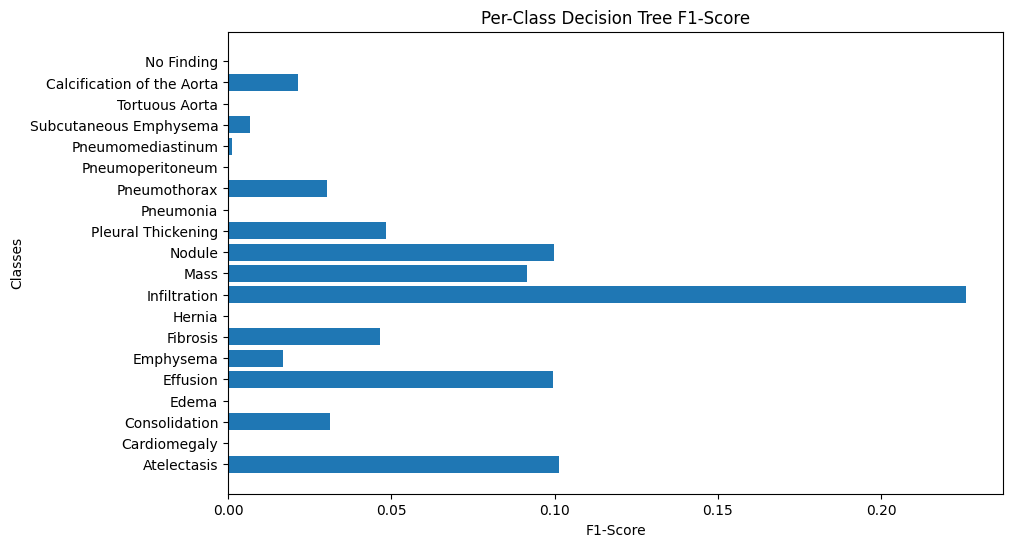

In [68]:
# Extract F1-scores for each class
f1_scores = dt_cr["f1-score"]

plt.figure(figsize=(10, 6))
plt.barh(list(label_map.keys()), f1_scores)
plt.xlabel("F1-Score")
plt.ylabel("Classes")
plt.title("Per-Class Decision Tree F1-Score")
plt.show()

In [76]:
y_test

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [73]:
def accuracy_score2(y_true,y_pred,normalize=True):
    accuracy=[]
    for i in range(len(y_pred)):
        for j in range(len(y_pred[i])):
            if y_pred[i][j]==y_true[i][j]:
                accuracy.append(1)
            else:
                accuracy.append(0)
    if normalize==True:
        return np.mean(accuracy)
    if normalize==False:
        return sum(accuracy)

In [74]:
accuracy_score2(y_test, dt_y_pred)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [64]:
print(root_mean_squared_error(y_test, dt_y_pred))
print(accuracy_score(y_test, dt_y_pred, normalize=True))


0.46338955576176355
0.0
